In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.utils import *
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csgraph import connected_components
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [29]:
data16 = np.load('img_features16.npy')
data64 = np.load('img_features64.npy')
data128 = np.load('img_features128.npy')

In [30]:
print(data16.shape)
print(data64.shape)
print(data128.shape)

(3857, 16, 16, 3)
(3857, 64, 64, 3)
(3857, 128, 128, 3)


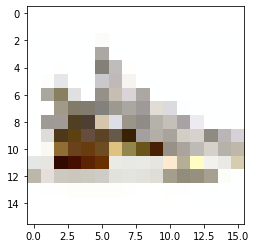

In [33]:
plt.imshow(data16[0])

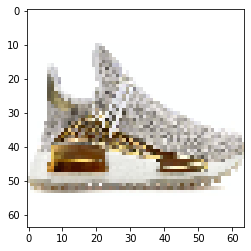

In [34]:
plt.imshow(data64[0])

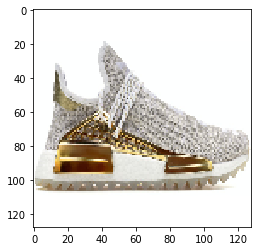

In [35]:
plt.imshow(data128[0])

In [7]:
img_table_and_df = pd.read_csv('img_table_and_df.csv')
img_table_and_df

,Unnamed: 0,0
0,0,adidas-y-3-tangutsu-blue
1,1,adidas-ozweego-model-pack
2,2,adidas-eqt-guidance-93-sneakersnstuff-tee-time
3,3,adidas-350-black-orange-yellow
4,4,adidas-nmd-xr1-winter-olive
...,...,...
3852,3852,adidas-campus-80s-undftd-x-bape-black
3853,3853,adidas-nite-jogger-ash-silver
3854,3854,adidas-continental-vulc-arizona-mucho-mango
3855,3855,adidas-zx-8000-bravo-fall-of-the-wall


今回は128×128×3の画像を使う

In [8]:
input1 = Input((128,128,3,))

conv1 = Conv2D(128, (2,2), padding='same', name='conv2D_1', kernel_initializer='he_normal')(input1)
conv1 = Conv2D(128, (2,2), padding='same', name='conv2D_2', kernel_initializer='he_normal')(conv1)
acti1 = Activation('relu', name='acti1')(conv1)
pool1 = MaxPool2D(pool_size=(2,2), name='pool1')(acti1)
drop1 = Dropout(0.2, name='drop1')(pool1)

conv2 = Conv2D(128, (2,2), padding='same', name='conv2D_3', kernel_initializer='he_normal')(drop1)
conv2 = Conv2D(128, (2,2), padding='same', name='conv2D_4', kernel_initializer='he_normal')(conv2)
acti2 = Activation('relu', name='acti2')(conv2)
pool2 = MaxPool2D(pool_size=(2,2), name='pool2')(acti2)
drop2 = Dropout(0.2, name='drop2')(pool2)

flat1 = Flatten(name='flat1')(drop2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
#### 出力を得たい層 ####
dens1 = Dense(512, name='hidden')(flat1)

acti3 = Activation('relu', name='acti3')(dens1)
dens2 = Dense(10,activation='softmax', name='end')(acti3)

model = Model(inputs=input1, outputs=dens2)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 128, 128, 128)     1664      
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 128, 128, 128)     65664     
_________________________________________________________________
acti1 (Activation)           (None, 128, 128, 128)     0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 128)       0         
_________________________________________________________________
drop1 (Dropout)              (None, 64, 64, 128)       0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 64, 64, 128)       6566

In [10]:
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [11]:
hidden = hidden_model.predict(data128)


In [12]:
hidden.shape

(3857, 512)

In [13]:
img_df = pd.DataFrame(hidden)

In [14]:
img_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.782812,-2.050811,0.018044,-2.663171,1.087005,-1.207252,3.465287,0.256284,2.695390,-0.229923,...,0.719867,-1.852574,-0.651291,5.204606,1.548740,1.164166,-0.230681,-1.908580,3.115953,-2.264680
1,-0.304381,-1.561025,-0.376956,-3.026709,1.955494,-2.858940,2.987722,-0.804959,1.785262,0.606527,...,-0.131859,-1.021410,-1.392078,5.217002,2.915419,0.508644,-2.413975,-3.159230,3.218507,-2.016574
2,0.067390,-1.986350,-0.476833,-2.596362,1.507128,-1.634411,2.762090,0.773319,2.263817,0.058120,...,0.076840,-1.534392,-1.210160,6.130643,1.747728,-0.344734,-0.669876,-2.810338,2.994319,-2.304341
3,0.191543,-1.301342,-0.181109,-1.980817,1.715767,-1.736957,2.783424,0.471755,2.347246,0.306438,...,0.279896,-1.623650,-1.566161,6.089378,2.337190,-0.217401,-0.322933,-2.391883,3.148532,-2.699173
4,0.786597,-1.643580,0.097614,-2.387701,1.446413,-1.157041,3.693467,0.079801,2.389032,1.168390,...,-0.279426,-1.087766,-1.910565,5.196601,2.178030,0.312388,-0.996793,-2.026626,1.459377,-1.906546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,0.489984,-2.306798,0.593304,-2.215571,1.460718,-1.086901,2.836732,1.184314,3.278926,0.333906,...,0.017851,-2.790787,-0.491353,5.441442,1.910351,0.400267,-0.805785,-1.230046,2.474618,-2.859581
3853,0.384898,-2.188559,-0.306377,-1.761149,1.403795,-2.027645,3.081894,-0.292191,2.946048,-0.472373,...,-0.230948,-1.050993,-1.338949,5.431038,2.153822,-0.795437,-1.026814,-3.024295,3.151481,-2.169280
3854,-0.035631,-2.026516,-0.136896,-3.153083,1.280360,-2.476304,3.131162,0.539518,3.271576,0.133556,...,0.254826,-1.512369,-1.143035,5.824551,2.687157,-0.031780,-1.819906,-2.769882,4.211026,-1.756631
3855,0.048086,-1.729818,-0.468946,-2.805052,1.872931,-1.048772,3.526198,-1.103863,2.312558,-0.139264,...,0.111334,-1.495571,-1.234590,5.353363,1.893479,-0.525103,-1.629709,-1.916214,3.034638,-1.319201


In [15]:
img_df.to_csv('img_df.csv')